## **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl 
import pandas.util.testing as tm
%matplotlib inline
mpl.rcParams['patch.force_edgecolor'] = True
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **Data Wrangling**

To simplify the process, we will remove hour, min, sec info since an "adopted" user is based on days.

In [2]:
#Import and process data
df_engagement = pd.read_csv('takehome_user_engagement.csv')

# Convert dates to datetime objects
df_engagement['time_stamp'] = list(map(lambda x: datetime.strptime(x.split()[0],'%Y-%m-%d'), df_engagement['time_stamp'])) # also removes hour, min, sec

print("Rows, columns: ", df_engagement.shape)
print("Earliest time_stamp: ", df_engagement['time_stamp'].min())
print("Latest time_stamp: ", df_engagement['time_stamp'].max(), '\n')
df_engagement.head()

Rows, columns:  (207917, 3)
Earliest time_stamp:  2012-05-31 00:00:00
Latest time_stamp:  2014-06-06 00:00:00 



,time_stamp,user_id,visited
0,2014-04-22,1,1
1,2013-11-15,2,1
2,2013-11-29,2,1
3,2013-12-09,2,1
4,2013-12-25,2,1


In [3]:
# Import data
df_users = pd.read_csv('takehome_users.csv',  encoding='latin-1')

# Convert dates to datetime objects
df_users['creation_time'] = list(map(lambda x: datetime.strptime(x.split()[0],'%Y-%m-%d'), df_users['creation_time'])) # also removes hour, min, sec

print("Rows, columns: ", df_users.shape)
print("Earliest creation_time: ", df_users['creation_time'].min())
print("Latest creation_time: ", df_users['creation_time'].max())
df_users.head()

Rows, columns:  (12000, 10)
Earliest creation_time:  2012-05-31 00:00:00
Latest creation_time:  2014-05-30 00:00:00


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


**Checking the number of users**

In [4]:
print("Number of unique user id's: ", len(df_users['object_id'].unique()))
print("Number of unique user names: ", len(df_users['name'].unique()))
print("Number of unique emails: ", len(df_users['email'].unique()))

Number of unique user id's:  12000
Number of unique user names:  11355
Number of unique emails:  11980


**Checking the distribution of logins**

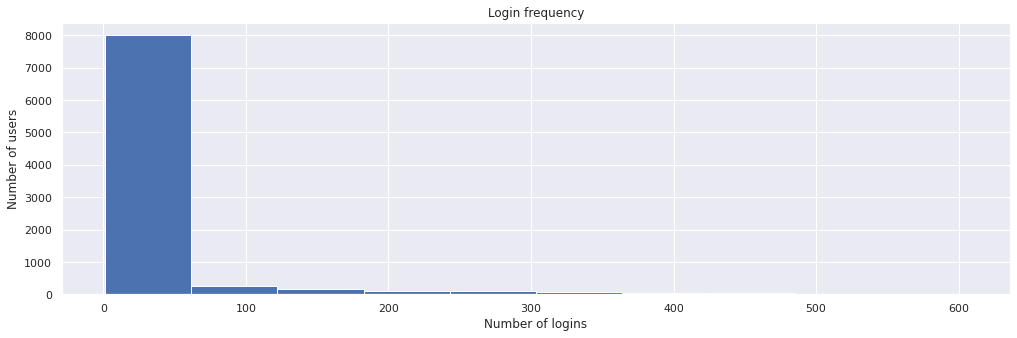

In [5]:
plt.figure(figsize=(17,5));
plt.hist(df_engagement.groupby('user_id').size());
plt.title('Login frequency');
plt.xlabel('Number of logins');
plt.ylabel('Number of users');

**Observations**

*   There are 12000 unique users. Although the number of unique user names (11355) and emails (11980) do not match up, there may be individuals who are duplicated in the database. 
*   If we assume that different individuals have identical names and also go by their email as a reference point to identify duplicate individuals, we would have only 20 duplicate individuals in our database. This is pretty small, so for us to keep things simple, we will stick with 'object_id' (user id) as the reference point for looking up each individual's login.
* This data spans between 2012-2014.
* Majority of users have less than 50 logins. There is also a small but significant cluster of users who are clearly active. Adopted users with greater than 100 logins.

## **Identify and Examine Adopted Users**

**Getting each user's login**

In [6]:
user_timestamps = [] # list of arrays, where each array is a user's logins
for idx, row in df_users.iterrows():
    user_id = row['object_id']
    timestamps = df_engagement[df_engagement['user_id']==user_id]['time_stamp']
    t = [i for i in timestamps]
    user_timestamps.append(t)


**Define function to determine whether a user has logged in on 3 separate days in at least one 7-day period**

Based on calculating time elapsed between each login. In the case multiple logins occur on the same day, which might confound this analysis, we remove these "duplicate" logins.

In [7]:
def adopted(x): # x = list of user's logins ('Timestamp' data type)
    if len(x) < 3:
        return 0
    else:
        x.sort()  
        y = [x[i+1] - x[i] for i in range(len(x)-2)] # amount of days between logins
        y = [i for i in y if i > timedelta(days=0)] # delete extra logins occurring on same day
        z = [1 for i in range(len(y)-2) if y[i] + y[i+1] + y[i+2] <= timedelta(days=7)]
        # To check if there`s a 1 in x, return 1 if true
        if 1 in z:
            return 1
        else:
            return 0


**Identify adopted users**

An adopted user is a user who has logged into the product on three separate days in at least one 7-day period.


In [8]:
adopt_total = []
for user in user_timestamps:
        adopt_total.append(adopted(user))

df_users['adopted'] = adopt_total

In [9]:
print("Number of adopted users: ", sum(adopt_total))
print("Fraction adopted users: ", sum(adopt_total)/len(adopt_total))

Number of adopted users:  1322
Fraction adopted users:  0.11016666666666666


11% of customers are adopted users. This means many users who aren't adopted will be valuable for the company to target.

## **Examine Features**

Making a dataframe of features, dropping the irrelevant columns. 

In [10]:
df_features = pd.DataFrame.copy(df_users)

In [11]:
df_features = pd.DataFrame.copy(df_users)
df_features = df_features.drop(['name', 'email', 'object_id', 'creation_time', 
                                'last_session_creation_time', 'invited_by_user_id'], axis=1)
df_features.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted
0,GUEST_INVITE,1,0,11,0
1,ORG_INVITE,0,0,1,0
2,ORG_INVITE,0,0,94,0
3,GUEST_INVITE,0,0,1,0
4,GUEST_INVITE,0,0,193,0


**Convert features to numeric**

The only feature we have to convert is 'creation_source'.

In [12]:
print('Unique creation sources: ', df_features['creation_source'].unique())

Unique creation sources:  ['GUEST_INVITE' 'ORG_INVITE' 'SIGNUP' 'PERSONAL_PROJECTS'
 'SIGNUP_GOOGLE_AUTH']


In [13]:
creation = {'GUEST_INVITE':0,
            'ORG_INVITE':1,
            'SIGNUP':2,
            'PERSONAL_PROJECTS':3,
            'SIGNUP_GOOGLE_AUTH':4}
df_features['creation_source'] = df_features['creation_source'].map(lambda i: creation[i])

**Examine the distribution of features**

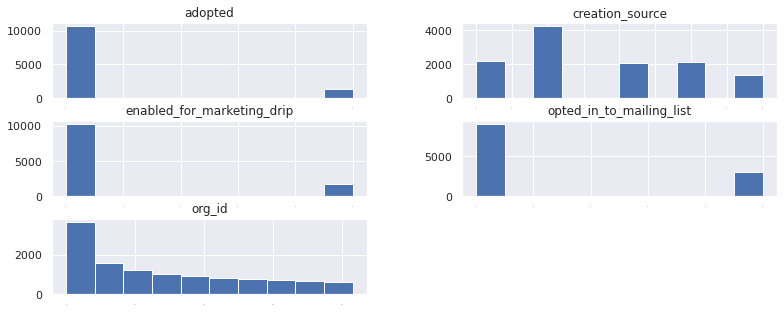

In [14]:
df_features.hist(sharex=False, sharey=False, xlabelsize=1, figsize=(13,5));

None of these features have a continuous normal distribution.

**Scale features**

We are choosing between StandardScaler and MinMaxScaler. MixmaxScale is more suitable for data that isn't normally distributed. From the above, we can see this is the case. So we will use MinMaxScaler.

In [15]:
from sklearn.preprocessing import MinMaxScaler

x = df_features.drop('adopted', axis=1)
y = df_users['adopted']

scaler = MinMaxScaler()
scaler.fit(x)
x = scaler.fit_transform(x)

In [16]:
# Temporarily put into dataframe to easily visualize how features have been converted
pd.DataFrame(x).head()

,0,1,2,3
0,0.00,1.0,0.0,0.026442
1,0.25,0.0,0.0,0.002404
2,0.25,0.0,0.0,0.225962
3,0.00,0.0,0.0,0.002404
4,0.00,0.0,0.0,0.463942


**Correlation matrix of features**

To examine whether there is correlation among the features.


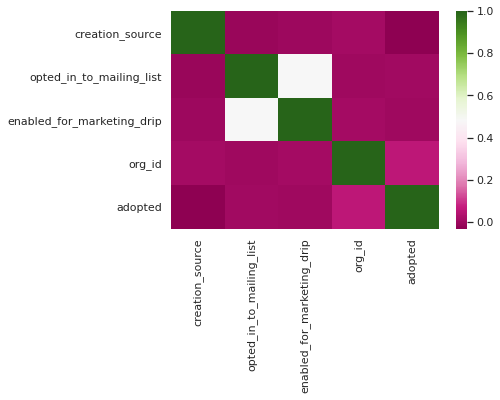

In [17]:
sns.heatmap(df_features.corr(), cmap="PiYG")

**'Enabled_for_marketing_drop'** and **'opted_in_to_mailing_list'** appear highly correlated. We will keep this in mind if we need to drop features to improve our model, since intercorrelated features may hinder model performance.

## **Test models**

We test out several models, narrowing down to one, then tuning parameters.

**Split features into train/test sets**

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=99)

**Testing multiple ML approaches at once**

In [19]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

#from sklearn.metrics import classification_report
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import accuracy_score
#from sklearn.pipeline import Pipeline


from sklearn.ensemble import RandomForestClassifier

num_folds=10
scoring='roc_auc'

models=[]
models.append(('LR', LogisticRegression()))
models.append(('KN', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('B', MultinomialNB()))

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=99, shuffle=True)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.566898 (0.022869)
KN: 0.549487 (0.030297)
RF: 0.547229 (0.023428)
B: 0.561615 (0.023597)


We pick logistic regression, since it has the best ROC-AUC.

**Tune model**

Tune the model to see if we can obtain further improvements.


In [20]:
from sklearn.metrics import confusion_matrix

# Re-instantiate model
model = LogisticRegression() # instantiate logreg w/ l1 regularization
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# Confusion matrix
print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))

Confusion matrix: 
[[3209    0]
 [ 391    0]]


*   The performance is great at not having any false positives (non-adopted users falsely identified as adopted). This means that no un-adopted user will slip through the cracks if Relax, Inc. ends up deciding to target non-adopted users with specific ads, etc. to retain them.
*   Although we have 391 false negatives - adopted users misclassified as non-adopted users maybe they will continue to be adopters, even if they get targeted with non-adopter ads, for example. This would mean the FN's (false negatives) are not costly. 

Regardless, let's see if we can get better performance with Lasso regularization

In [21]:
model = LogisticRegression(penalty='l2') 
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# Confusion matrix
print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))

Confusion matrix: 
[[3209    0]
 [ 391    0]]


It's actually the same here in this case. Perhaps not just for this train/test split, but the difference seems likely to be small.

## **Examine feature importance**
Plot relative importance of features

Text(0.5, 1.0, 'Relative importance of features')

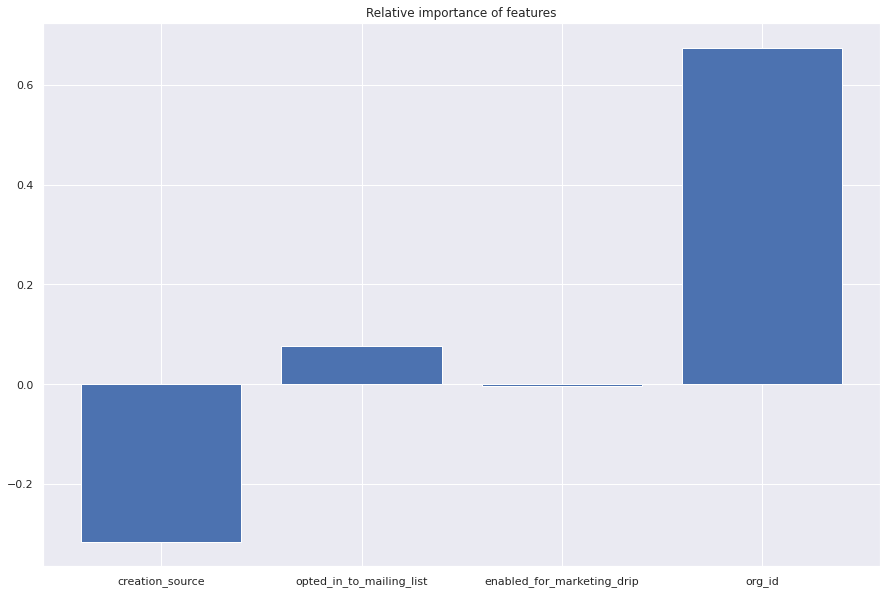

In [22]:
features = df_features.columns[:-1].tolist()
coefs = model.coef_[0]

plt.figure(figsize=(15,10));
plt.bar(features, coefs);
plt.title('Relative importance of features')

**'creation_source'** and **'org_id'** seem to be most important features. It is difficult to make a specific recommendation since we only know that they are heavily weighted. So let's take a closer look. 

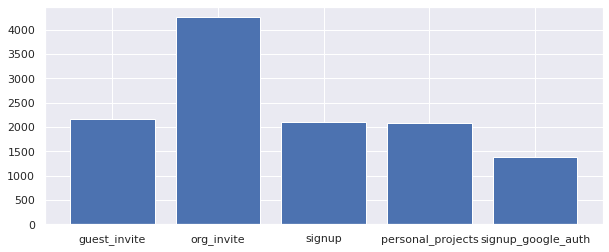

In [23]:
names = ['guest_invite', 'org_invite', 'signup', 'personal_projects', 'signup_google_auth']
count = df_users.groupby('creation_source').size().tolist()

plt.figure(figsize=(10,4));
plt.bar(names, count);

The most common creation source seems to be **'org_invite'**. This makes sense, since **'org_id'** is our other feature with a relatively large weight. Let's examine **'org_id'** next.

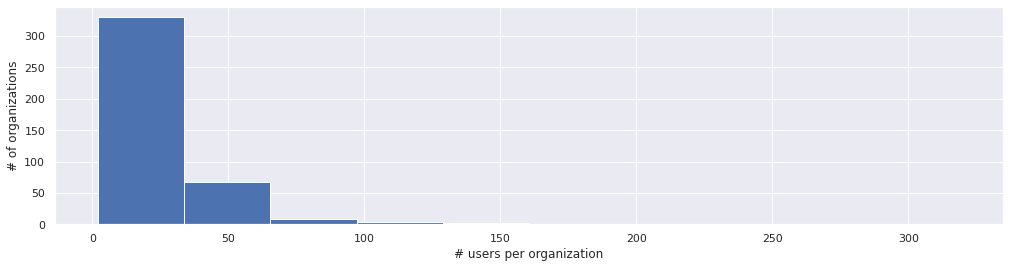

In [24]:
count = df_users.groupby('org_id').size()
plt.figure(figsize=(17,4))
plt.hist(count);
plt.xlabel('# users per organization');
plt.ylabel('# of organizations');

The majority of organizations (group of users, by 'org_id') seem to have greater than 70 members. However, there are a few large organizations with many more members. Let's examine those more closely.

Total organizations with greater than 70 users:  18


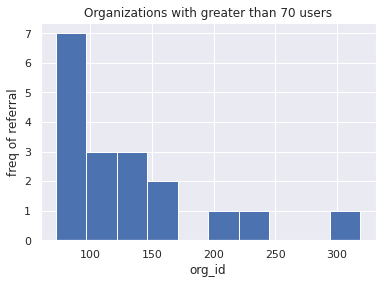

In [25]:
test = pd.DataFrame({'count':count.tolist(), 'org_id':count.index})
test = test[test['count'] > 70]['count']
plt.hist(test);
plt.xlabel('org_id');
plt.ylabel('freq of referral');
plt.title('Organizations with greater than 70 users');
print('Total organizations with greater than 70 users: ', len(test))

There are 18 organizations with greater than 70 users. These organizations might be worth targeting to get more even users.

## **Conclusion**

Our most important features were 'org_id' and 'creation_source'. It seems many of Relax Inc's users are influenced to adopt by principle of being part of an organization or in whatever way they were invited.

Upon closer examination of these features, whether the user was prompted to adopt due to being part of an organization is probably the most important factor in determining whether they adopt. There are about 18 organizations with more than 70 users.

**Recommendation:** To increase number of adopters, it may be more worthwhile to target organizations rather than individual customers - particularly focusing on encouraging organizations to enroll large numbers of their members. Individual-level factors such as how users signed up (not including by an organization) and whether they were on a mailing list are not nearly as important as whether they were part of an organization.